# Survive your commuting
In this notebook, we deal with the UK road safety dataset from 1979 to 2015: we plot several relevant features to get an idea of where and when do accidents happens, who is the most common victims etc. To do so, we also visualize accident distribution across the country, without surprise a majority of accidents happens in urban areas.


In [1]:
#import
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import folium.plugins
from scipy import stats, spatial
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import dl_data

In [45]:
#HELPERS

def plot_distrib(acc, group = "Day_of_Week", colname = 'index', ax = None, leg = ""):
    """
    Plot the distribution of colname per group
    """
    if colname == 'index':
        acc[acc[group] != -1].groupby([group]).count().iloc[:,0].plot.bar(x = group, 
                                                       title = "Accidents distribution per {} {}".format(group, leg),
                                                       ax = ax)
    else:
        acc[acc[group] != -1].groupby([group])[colname].sum().plot.bar(x = group, 
                                                     title = "{} distribution per {} {}".format(colname, group, leg),
                                                     ax = ax)                        


In [3]:
#download the dataset
accidents, casualties, vehicules = dl_data.dl()

Begin download...
Accidents0514.csv
Casualties0514.csv
Vehicles0514.csv
Accidents_2015.csv


/anaconda3/envs/xadax/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Casualties_2015.csv
Vehicles_2015.csv
Begin cleaning...


>We decided not to use the oldest data because it has a lot of missing values in addition with being completely outdated. This choice was also motivated by the deprecation of its format: it lacks some features and some feature names have been changed for the two other periods.

## Visualise some of the features
> We want to put things into perspectives: understand the distribution of accidents across time and space.

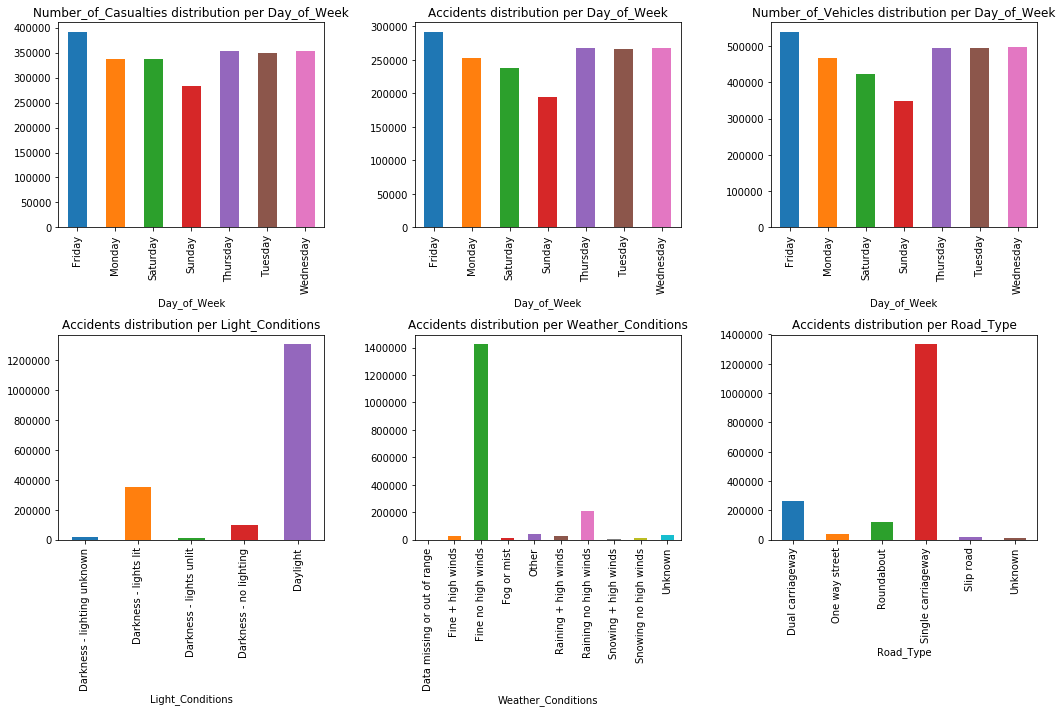

In [4]:
#Weekly distribution, plots using the accidents dataframe
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
plot_distrib(accidents, colname = "Number_of_Casualties", ax = axes[0][0])
plot_distrib(accidents, ax = axes[0][1])
plot_distrib(accidents, colname = "Number_of_Vehicles", ax = axes[0][2])
plot_distrib(accidents, group = "Light_Conditions", ax = axes[1][0])
plot_distrib(accidents, group = "Weather_Conditions", ax = axes[1][1])
plot_distrib(accidents, group ="Road_Type", ax = axes[1][2])
fig.tight_layout()


> *Weekly distribution*: days appear to have the same distribution accross the week except for Sunday and Friday. Actually, Sunday has the lowest figure: one can assume tha people take less frequently their cars on week-ends or that there are less cars on the road because they are full. On the contrary, Friday has the highest number of accident, is it due to the week-end leave after work? We could dig deeper to see if it is equally distributed between morning and afternoon... 
>>What's more there are more wounded people but less vehicles on Sunday compared to Monday. It could be explained by the fact that on Sunday people are traveling with their family: cars are almost full. While, on Monday people are commuting: one person by car.

> *Driving conditions*: We need to have more data to draw any conclusions regarding the light and weather conditions: we can observe that there is more accidents for a particular set of conditions but it is likely to be the most common set (for instance daylight: most people uses their car during the day and sleep at night).


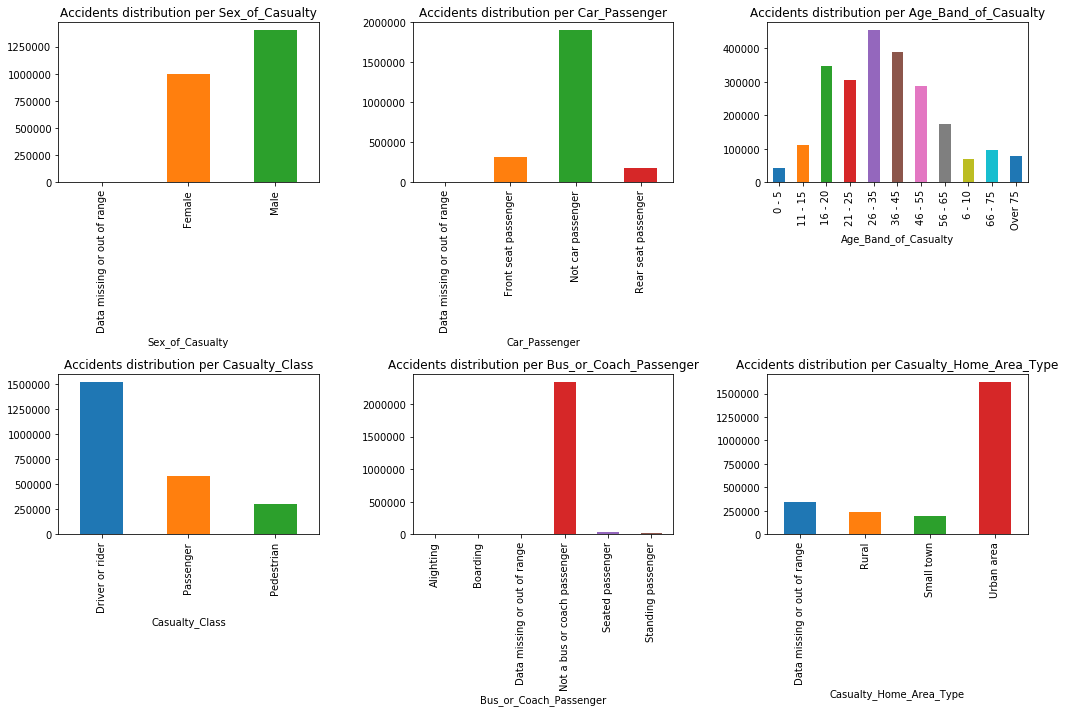

In [5]:
#plot using the casualties dataframe
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
plot_distrib(casualties, group = "Sex_of_Casualty", ax = axes[0][0])
plot_distrib(casualties, group = "Casualty_Class", ax = axes[1][0])
plot_distrib(casualties, group = "Age_Band_of_Casualty", ax = axes[0][2])
plot_distrib(casualties, group = "Car_Passenger", ax = axes[0][1])
plot_distrib(casualties, group = "Bus_or_Coach_Passenger", ax = axes[1][1])
plot_distrib(casualties, group = "Casualty_Home_Area_Type", ax = axes[1][2])
fig.tight_layout()


>Without suprise, we observe that there are more men than women among casualties: statistically speaking men have more car accidents than women. Similarly, the majority of the casualties is among adult (from 20 to 60), people who have more chance to be one the road either as a driver, a passenger or a pedestrian.

> The graph about the bus or coach passenger shows that most casualties are not on a bus. One can assume that bus are less involved in road accidents and therefore make less casualties.

> Most casualties live in urban areas, why is that? The map below might explain this figure.

# Marion s'amuse

In [6]:
accidents.head()

,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),...,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident
0,-0.191170,51.489096,Metropolitan Police,Serious,1,1,2005-01-04,Tuesday,1900-01-01 17:42:00,Kensington and Chelsea,...,0,0,1,Daylight,Raining no high winds,2,None,None,1,1
1,-0.211708,51.520075,Metropolitan Police,Slight,1,1,2005-01-05,Wednesday,1900-01-01 17:36:00,Kensington and Chelsea,...,0,0,5,Darkness - lights lit,Fine no high winds,1,None,None,1,1
2,-0.206458,51.525301,Metropolitan Police,Slight,2,1,2005-01-06,Thursday,1900-01-01 00:15:00,Kensington and Chelsea,...,0,0,0,Darkness - lights lit,Fine no high winds,1,None,None,1,1
3,-0.173862,51.482442,Metropolitan Police,Slight,1,1,2005-01-07,Friday,1900-01-01 10:35:00,Kensington and Chelsea,...,0,0,0,Daylight,Fine no high winds,1,None,None,1,1
4,-0.156618,51.495752,Metropolitan Police,Slight,1,1,2005-01-10,Monday,1900-01-01 21:13:00,Kensington and Chelsea,...,0,0,0,Darkness - lighting unknown,Fine no high winds,2,None,None,1,1


In [7]:
casualties.head()

,Accident_Index,Vehicle_Reference,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Pedestrian_Location,Pedestrian_Movement,Car_Passenger,Bus_or_Coach_Passenger,Pedestrian_Road_Maintenance_Worker,Casualty_Type,Casualty_Home_Area_Type
0,200501BS00001,1,1,Pedestrian,Male,36 - 45,Serious,1,1,Not car passenger,Not a bus or coach passenger,-1,Pedestrian,Urban area
1,200501BS00002,1,1,Passenger,Male,36 - 45,Slight,0,0,Not car passenger,Seated passenger,-1,Bus or coach occupant (17 or more pass seats),Urban area
2,200501BS00003,2,1,Driver or rider,Male,56 - 65,Slight,0,0,Not car passenger,Not a bus or coach passenger,-1,Car occupant,Urban area
3,200501BS00004,1,1,Pedestrian,Male,26 - 35,Slight,5,2,Not car passenger,Not a bus or coach passenger,-1,Pedestrian,Urban area
4,200501BS00005,1,1,Driver or rider,Male,46 - 55,Slight,0,0,Not car passenger,Not a bus or coach passenger,-1,Motorcycle 125cc and under rider or passenger,Data missing or out of range


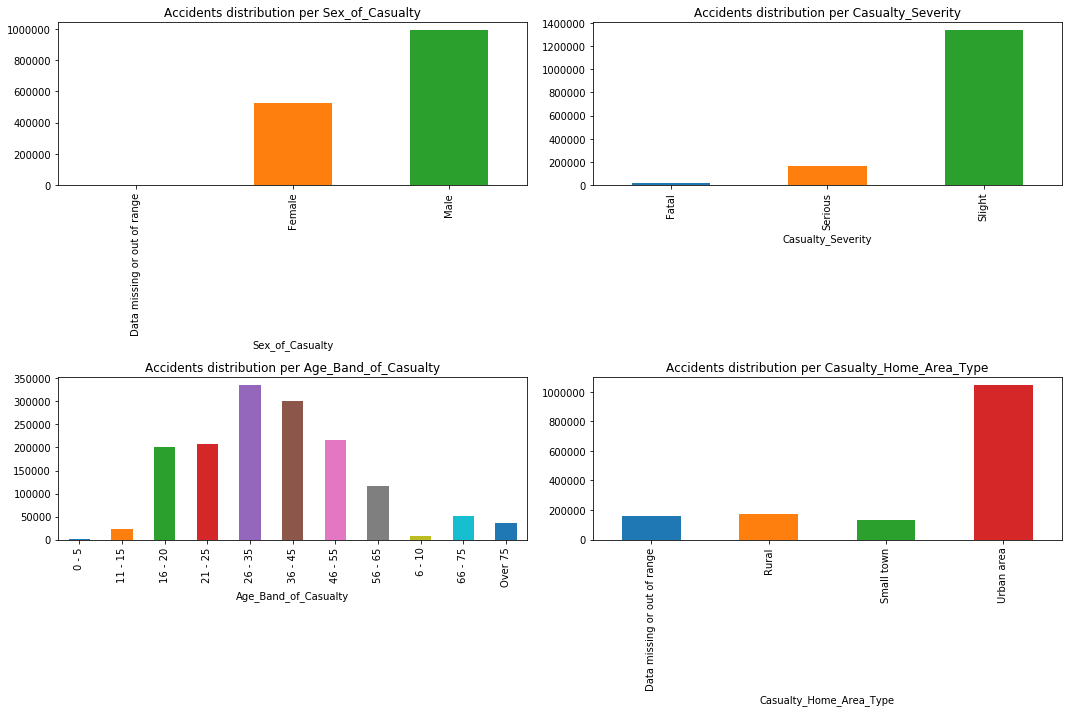

In [8]:
#plot using the casualties dataframe
drivers = casualties[casualties['Casualty_Class'] == 'Driver or rider']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
plot_distrib(drivers, group = "Sex_of_Casualty", ax = axes[0][0])
plot_distrib(drivers, group = "Casualty_Severity", ax = axes[0][1])
plot_distrib(drivers, group = "Age_Band_of_Casualty", ax = axes[1][0])
plot_distrib(drivers, group = "Casualty_Home_Area_Type", ax = axes[1][1])

fig.tight_layout()


In [34]:
accidents['year'] = pd.DatetimeIndex(accidents['Date']).year
accidents['hour'] = pd.DatetimeIndex(accidents['Time']).hour


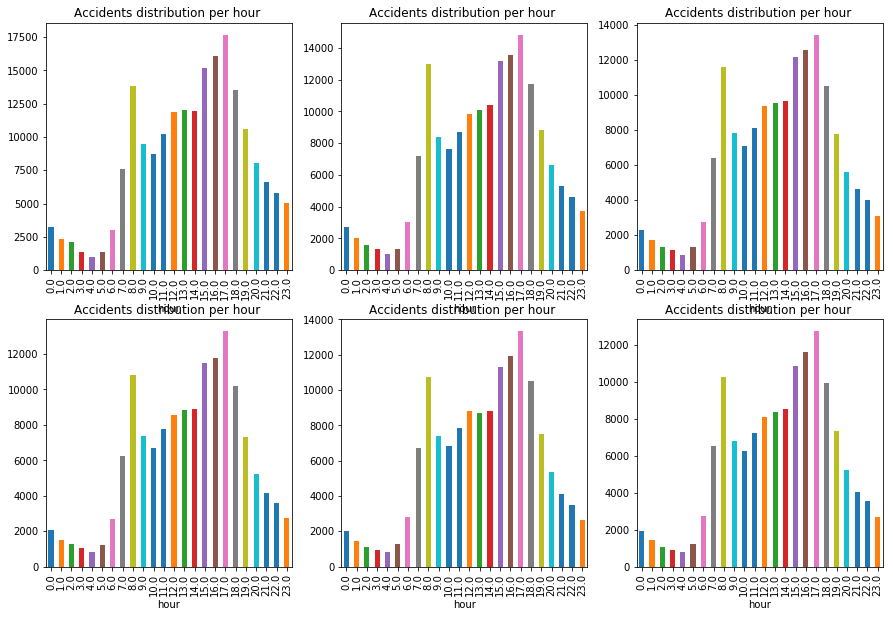

In [51]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

plot_distrib(accidents[accidents['year'] == 2005], group = "hour", ax = axes[0][0])
plot_distrib(accidents[accidents['year'] == 2008], group = "hour", ax = axes[0][1])
plot_distrib(accidents[accidents['year'] == 2010], group = "hour", ax = axes[0][2])
plot_distrib(accidents[accidents['year'] == 2012], group = "hour", ax = axes[1][0])
plot_distrib(accidents[accidents['year'] == 2014], group = "hour", ax = axes[1][1])
plot_distrib(accidents[accidents['year'] == 2015], group = "hour", ax = axes[1][2])



In [52]:
def plot_per_hour(df):
    df['year'] = pd.DatetimeIndex(df['Date']).year
    df['hour'] = pd.DatetimeIndex(df['Time']).hour
    
    df_2015 = df[df['year'] == 2015]

    fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharey = True)

    plot_distrib(df_2015[df_2015['Day_of_Week'] == 'Monday'], group = "hour", ax = axes[0][0], leg = "Monday")
    plot_distrib(df_2015[df_2015['Day_of_Week'] == 'Tuesday'], group = "hour", ax = axes[0][1], leg = "Tuesday")
    plot_distrib(df_2015[df_2015['Day_of_Week'] == 'Wednesday'], group = "hour", ax = axes[0][2], leg = "Wednesday")
    plot_distrib(df_2015[df_2015['Day_of_Week'] == 'Thursday'], group = "hour", ax = axes[1][0], leg = "Thursday")
    plot_distrib(df_2015[df_2015['Day_of_Week'] == 'Friday'], group = "hour", ax = axes[1][1], leg = "Friday")
    plot_distrib(df_2015[df_2015['Day_of_Week'] == 'Saturday'], group = "hour", ax = axes[1][2], leg = "Saturday")
    plot_distrib(df_2015[df_2015['Day_of_Week'] == 'Sunday'], group = "hour", ax = axes[2][0], leg = "Sunday")


    fig.tight_layout()


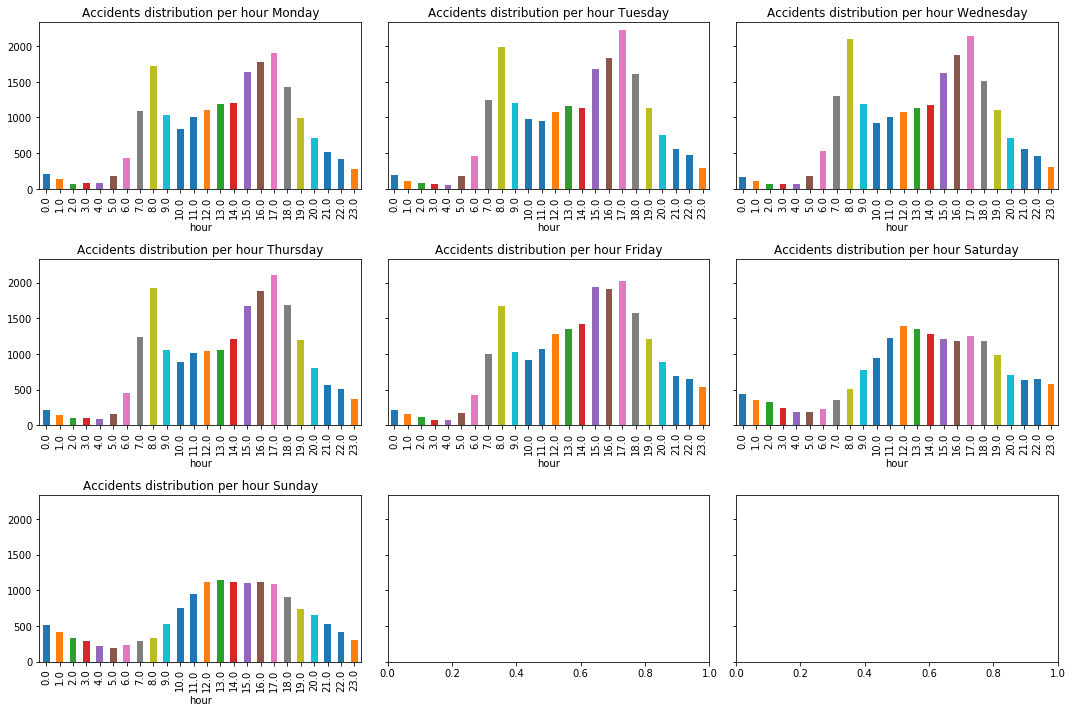

In [53]:
plot_per_hour(accidents)

In [55]:

plot_per_hour(casualties)

KeyError: 'Date'

In [56]:
casualties.columns

Index(['Accident_Index', 'Vehicle_Reference', 'Casualty_Reference',
       'Casualty_Class', 'Sex_of_Casualty', 'Age_Band_of_Casualty',
       'Casualty_Severity', 'Pedestrian_Location', 'Pedestrian_Movement',
       'Car_Passenger', 'Bus_or_Coach_Passenger',
       'Pedestrian_Road_Maintenance_Worker', 'Casualty_Type',
       'Casualty_Home_Area_Type'],
      dtype='object')

## Map visualization

In [59]:
# Plot every accidents in the UK from 2005 to 2014
london_coord = [55.3780518, -3.4359729]
m = folium.Map(location=london_coord, zoom_start=5)
marker_cluster = folium.plugins.marker_cluster.MarkerCluster().add_to(m)
for acc in accidents.sample(2000).itertuples():
    folium.Marker([acc.Latitude, acc.Longitude]).add_to(marker_cluster)
m.save("bubles.html")

In [15]:
# Plot the approximate density of accidents in the UK
m = folium.Map(location=london_coord, zoom_start=5)
folium.plugins.HeatMap(accidents[['Latitude', 'Longitude', 'Number_of_Casualties']].sample(2000).values).add_to(m)
m.save("density.html")

In [16]:
acc_per_year_and_month = accidents[['Latitude', 'Longitude', 'Number_of_Casualties']].groupby([accidents.Date.dt.year, accidents.Date.dt.month])
times = list(map(lambda i: datetime.datetime(i[0], i[1], 1).strftime('%b %Y'), acc_per_year_and_month.indices))
# Plot the approximate density of accidents in the UK year per year
m = folium.Map(location=london_coord, zoom_start=5)
folium.plugins.HeatMapWithTime([acc_per_year_and_month.get_group(gr).sample(2000).values.tolist()
                                for gr in acc_per_year_and_month.indices], index=times).add_to(m)
m.save("density_by_year.html")

> We saved the results of the maps as html files to look at separetely. Those are very interesting when we look at an important zoom level. When too zoomed out, we don't see very much what is happening. 

## Historic analysis
Since data is available for different periods, we would like to understand how it has evolve for the last 10 years.

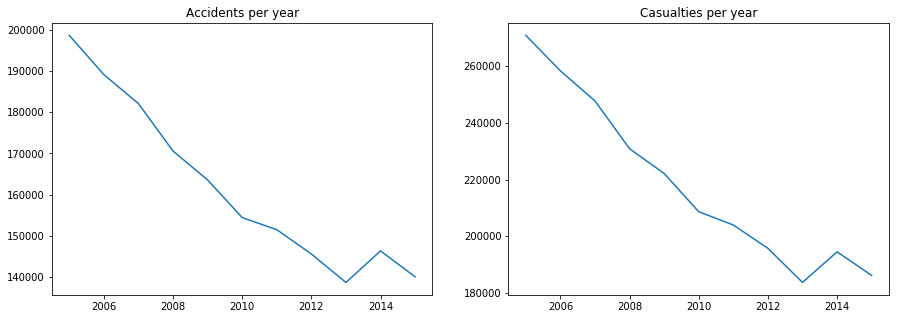

In [98]:
# Plot casualties per year: we expect a decrease
accidents_per_year = accidents.groupby([accidents.Date.dt.year, accidents.Urban_or_Rural_Area]).size()
casualties_per_year = accidents.groupby([accidents.Date.dt.year, accidents.Urban_or_Rural_Area])\
    .agg({'Number_of_Casualties': 'sum'})
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(years, accidents_per_year.groupby('Date').sum().values)
ax1.set_title("Accidents per year")
ax2.plot(years, casualties_per_year.groupby('Date').sum().values)
ax2.set_title("Casualties per year");

> We see that there is a sharp decrease in the number of accidents and casualties since 2005. Since the slope is almost linear, this seems to be a general trend and the policies applied during this period doesn't seem to have an important effect on it. However, there is a bump in 2014 that seem worth working on.

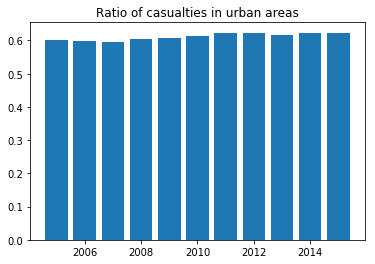

In [18]:
# Plot the ratio of casualties in urban areas
plt.bar(years, [casualties_per_year.loc[y, 1][0] / (casualties_per_year.loc[y, 1][0] + casualties_per_year.loc[y, 2][0]) for y in years])
plt.title("Ratio of casualties in urban areas");

> The ratio of casualities in urban area doesn't change very much from year to year and seems to be quite stable. So it doesn't seem to be a very interesting metric to look at across the years.

In [11]:
# Printing correlation coefficients between different metrics
stats.pearsonr(accidents['Number_of_Casualties'], accidents['Urban_or_Rural_Area'])[0]

0.11584093486922468

In [14]:
stats.pearsonr(accidents['Number_of_Casualties'], accidents['Day_of_Week'])[0]

-0.0009435498643436669

In [13]:
stats.pearsonr(accidents['Number_of_Casualties'], accidents['Weather_Conditions'])[0]

-0.004562074734779527

In [18]:
stats.pearsonr(accidents['Number_of_Casualties'], accidents['Light_Conditions'])[0]

0.036734382808058005

In [17]:
stats.pearsonr(accidents['Number_of_Casualties'], accidents['1st_Road_Class'])[0]

-0.08293703075694672

> After a first look at the correlation coefficient, we should deepen our analysis to understand why some factors seem to be much more important than others for instance why is the area more important than the weather ? Besides, most people believe that weather conditions and accidents likelihodd are strongly connected. Can we explain such beliefs with our dataset ?

dict_values([Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            198590, 198592, 198593, 198594, 198595, 198596, 198597, 198598,
            198599, 198606],
           dtype='int64', length=16275), Int64Index([    28,     29,     30,     31,     32,     33,     34,     35,
                36,     37,
            ...
            198415, 198416, 198417, 198418, 198591, 198600, 198601, 198602,
            198603, 198604],
           dtype='int64', length=14520), Int64Index([    67,     78,     79,     81,     84,     85,     86,     87,
                88,     89,
            ...
            198435, 198436, 198446, 198605, 198607, 198608, 198609, 198610,
            198611, 198615],
           dtype='int64', length=14973), Int64Index([   134,    135,    136,    139,    141,    142,    143,    144,
               145,    146,
            ...
            198617, 198618, 198619, 198620, 198621, 198622, 198623, 1

In [ ]:
# Let's try to predict the number of casualties with the condition of the accident
X = accidents[[#Space and time context
    'Number_of_Casualties',
            'Time', 'Longitude', 'Latitude', 'Day_of_Week',
            'Number_of_Vehicles',
            #Visibility and road conditions
            'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions', 'Special_Conditions_at_Site', 'Carriageway_Hazards',
            'Urban_or_Rural_Area'
           ]]
X.Time = X.Time.dt.hour
X.dropna(axis=0, inplace=True)
y = X['Number_of_Casualties']
X.drop('Number_of_Casualties', axis=1, inplace=True)
clf = LogisticRegression()
cross_val_score(clf, X.values, y.values, cv=3)

/home/sebastien/venv/nn/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/home/sebastien/venv/nn/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/sebastien/venv/nn/lib/python3.6/site-packages/sklearn/model_selection/_split.py:626: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/home/sebastien/venv/nn/lib/python3.6/site-packages/s

## Correlation between weather and casualties

In [202]:
acc_per_weather = accidents.groupby('Weather_Conditions').size()
acc_per_weather_ratio = acc_per_weather.divide(acc_per_weather.sum())
acc_per_weather_ratio = acc_per_weather_ratio.groupby(acc_per_weather_ratio.index.str.contains('Fine')).sum()
average_num_of_casualties_per_weather = accidents.groupby('Weather_Conditions').agg({'Number_of_Casualties': ['mean', 'std']})
average_num_of_casualties_per_weather

Number_of_Casualties          
                                             mean       std
Weather_Conditions                                         
Data missing or out of range             1.440994  0.835499
Fine + high winds                        1.378260  0.835757
Fine no high winds                       1.344009  0.816877
Fog or mist                              1.443906  1.320310
Other                                    1.351421  0.799223
Raining + high winds                     1.395103  0.875692
Raining no high winds                    1.391909  0.852502
Snowing + high winds                     1.431730  1.214611
Snowing no high winds                    1.346076  0.726516
Unknown                                  1.226584  0.694742

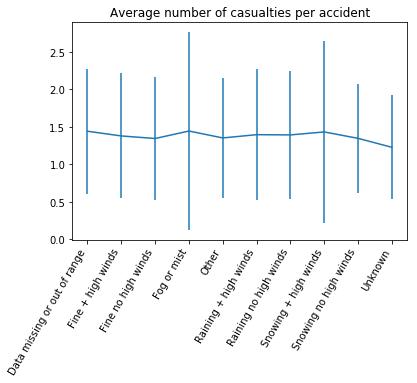

In [51]:
plt.errorbar(average_num_of_casualties_per_weather.index,
             average_num_of_casualties_per_weather['Number_of_Casualties']['mean'],
            average_num_of_casualties_per_weather['Number_of_Casualties']['std']);
plt.title('Average number of casualties per accident')
plt.xticks(rotation=60, ha='right');

> This plot illustrates the fact that the number of casualties per accident does not vary significantly with the weather contradicting, the common knowledge that driving when the weather is poor is more dangerous. Therefore, we could to try to spot a difference in the number of accidents, but we must find a proper normalization first.

In [55]:
accidents.groupby([accidents.Date, 'Weather_Conditions']).size()

Date        Weather_Conditions   
2005-01-01  Fine + high winds         12
            Fine no high winds       194
            Other                     11
            Raining + high winds      27
            Raining no high winds     57
            Snowing + high winds       4
            Unknown                    3
2005-01-02  Fine + high winds         15
            Fine no high winds       240
            Other                     12
            Raining + high winds       6
            Raining no high winds     16
            Snowing + high winds       6
            Snowing no high winds      4
            Unknown                    6
2005-01-03  Fine + high winds         13
            Fine no high winds       254
            Other                      8
            Raining + high winds       4
            Raining no high winds      6
            Unknown                    8
2005-01-04  Fine + high winds         47
            Fine no high winds       278
            Other      

## Most dangerous places

In [101]:
def to_bins(data, n_bins):
    width = (data.max() - data.min()) / n_bins
    return data.map(lambda x: np.ceil(x / width) * width)

accidents['Latitude_bin'] = to_bins(accidents.Latitude, 10000)
accidents['Longitude_bin'] = to_bins(accidents.Longitude, 10000)
acc_per_latlng = accidents.groupby(['Latitude_bin', 'Longitude_bin'])

In [104]:
# Get the index of the place with the most casualties
sorted_acc_per_latlng = acc_per_latlng.agg({'Number_of_Casualties': 'sum'}).sort_values('Number_of_Casualties', ascending=False)

In [60]:
acc_at_loc = acc_per_latlng.get_group((51.57150956649999, -0.09556582050000001))
m = folium.Map(location=london_coord, zoom_start=5)
marker_cluster = folium.plugins.marker_cluster.MarkerCluster().add_to(m)
for acc in acc_at_loc.itertuples():
    folium.Marker([acc.Latitude, acc.Longitude]).add_to(marker_cluster)
m

> Now that we have an especially dangerous place, let's try and look what settings made the accidents happen.

In [63]:
acc_at_loc.describe()

,Longitude,Latitude,Number_of_Vehicles,Number_of_Casualties,1st_Road_Number,Speed_limit,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Road_Surface_Conditions,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,Latitude_bin,Longitude_bin
count,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.0,187.000000,187.000000,187.0,187.000000,187.00000,187.000000
mean,-0.096016,51.570649,1.839572,1.304813,261.935829,30.962567,321.294118,0.0,4.336898,1.240642,1.0,1.144385,51.57151,-0.095566
std,0.000145,0.000136,0.459003,0.828347,195.752274,4.033954,205.106749,0.0,1.703531,0.539669,0.0,0.352423,0.00000,0.000000
min,-0.096417,51.570497,1.000000,1.000000,0.000000,30.000000,0.000000,0.0,0.000000,1.000000,1.0,1.000000,51.57151,-0.095566
25%,-0.096037,51.570589,2.000000,1.000000,105.000000,30.000000,105.000000,0.0,5.000000,1.000000,1.0,1.000000,51.57151,-0.095566
50%,-0.096015,51.570594,2.000000,1.000000,105.000000,30.000000,503.000000,0.0,5.000000,1.000000,1.0,1.000000,51.57151,-0.095566
75%,-0.096011,51.570682,2.000000,1.000000,503.000000,30.000000,503.000000,0.0,5.000000,1.000000,1.0,1.000000,51.57151,-0.095566
max,-0.095567,51.571318,3.000000,8.000000,503.000000,50.000000,503.000000,0.0,7.000000,4.000000,1.0,2.000000,51.57151,-0.095566


In [203]:
# Let's compute the number of accidents for each weather condition
# and weight that with the total ratio of accidents per weather condition
at_loc = acc_at_loc.groupby('Weather_Conditions').size()
at_loc = at_loc[~at_loc.index.str.match('Data missing or out of range|Unknown')]
at_loc = at_loc.groupby(at_loc.index.str.contains('Fine')).sum().divide(acc_per_weather_ratio)
at_loc

False    10.656630
True     28.313846
dtype: float64

> On that particular example, it's clear that weather highly correlates with the number of accidents! Let's see if we can generalize that statement.

In [205]:
# Let's compute the weather effect on the 20 most accidentogenous places
weather_effect = pd.DataFrame()
for lat_lng in sorted_acc_per_latlng.index[:20]:
    acc_at_loc = acc_per_latlng.get_group(lat_lng)
    at_loc = acc_at_loc.groupby('Weather_Conditions').size()
    at_loc = at_loc[~at_loc.index.str.match('Data missing or out of range|Unknown')]
    weather_effect[lat_lng] = at_loc.groupby(at_loc.index.str.contains('Fine')).sum().divide(acc_per_weather_ratio)
weather_effect.rename(index={True: 'Fine weather', False: 'Bad weather'}, inplace=True)

In [206]:
weather_effect.apply(lambda r: (pd.DataFrame.mean(r), pd.Series.std(r)), axis=1)

Bad weather     (71.13300250478063, 19.80701751737631)
Fine weather    (129.1357603325327, 24.19559733496826)
dtype: object

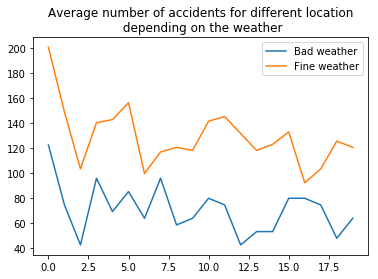

In [207]:
plt.plot(np.arange(len(weather_effect.loc['Bad weather'])), weather_effect.loc['Bad weather'].values, label='Bad weather')
plt.plot(np.arange(len(weather_effect.loc['Bad weather'])), weather_effect.loc['Fine weather'].values, label='Fine weather')
plt.legend()
plt.title("Average number of accidents for different location\n depending on the weather");

In [208]:
stats.ttest_ind(weather_effect.loc['Bad weather'].values, weather_effect.loc['Fine weather'].values, equal_var=False)

Ttest_indResult(statistic=-8.295658534347048, pvalue=6.292931528414396e-10)

> We can thus reject the null hypothesis that there are on average as much accidents when the weather is fine than when it is bad with a 5% signifiance level. This analysis show clearly that fine weather is less accidentogenous in places where accidents happen regularly. The pattern of this analysis can be extended to many more factors and provide a practical way of normalizing these factors.

False    0.187677
True     0.812323
dtype: float64